In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [3]:
os.listdir('C:/Users/ASUS/Untitled Folder/Sample-TA/datasets/train/audio')

['1', '2', '3', '4', '5', 'a', 'b', 'c', 'd', 'e', 'ehmm', 'pstt', 'uhuk uhuk']

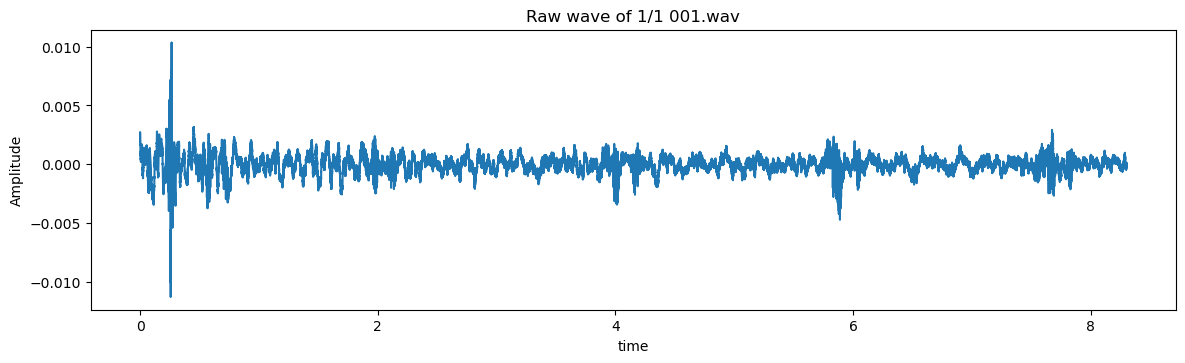

In [7]:
train_audio_path = 'C:/Users/ASUS/Untitled Folder/Sample-TA/datasets/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'1/1 001.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of '+'1/1 001.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')

time = np.linspace(0, len(samples) / sample_rate, len(samples))
ax1.plot(time, samples)

In [8]:
#sampling (contoh)
ipd.Audio(samples, rate=sample_rate)

In [9]:
print(sample_rate)

16000


In [15]:
# Resampling (changing the sample rate)
target_sr = 8000
samples = librosa.resample(samples, target_sr)
ipd.Audio(samples, rate=target_sr)


TypeError: resample() takes 1 positional argument but 2 were given

In [22]:
labels=os.listdir(train_audio_path)

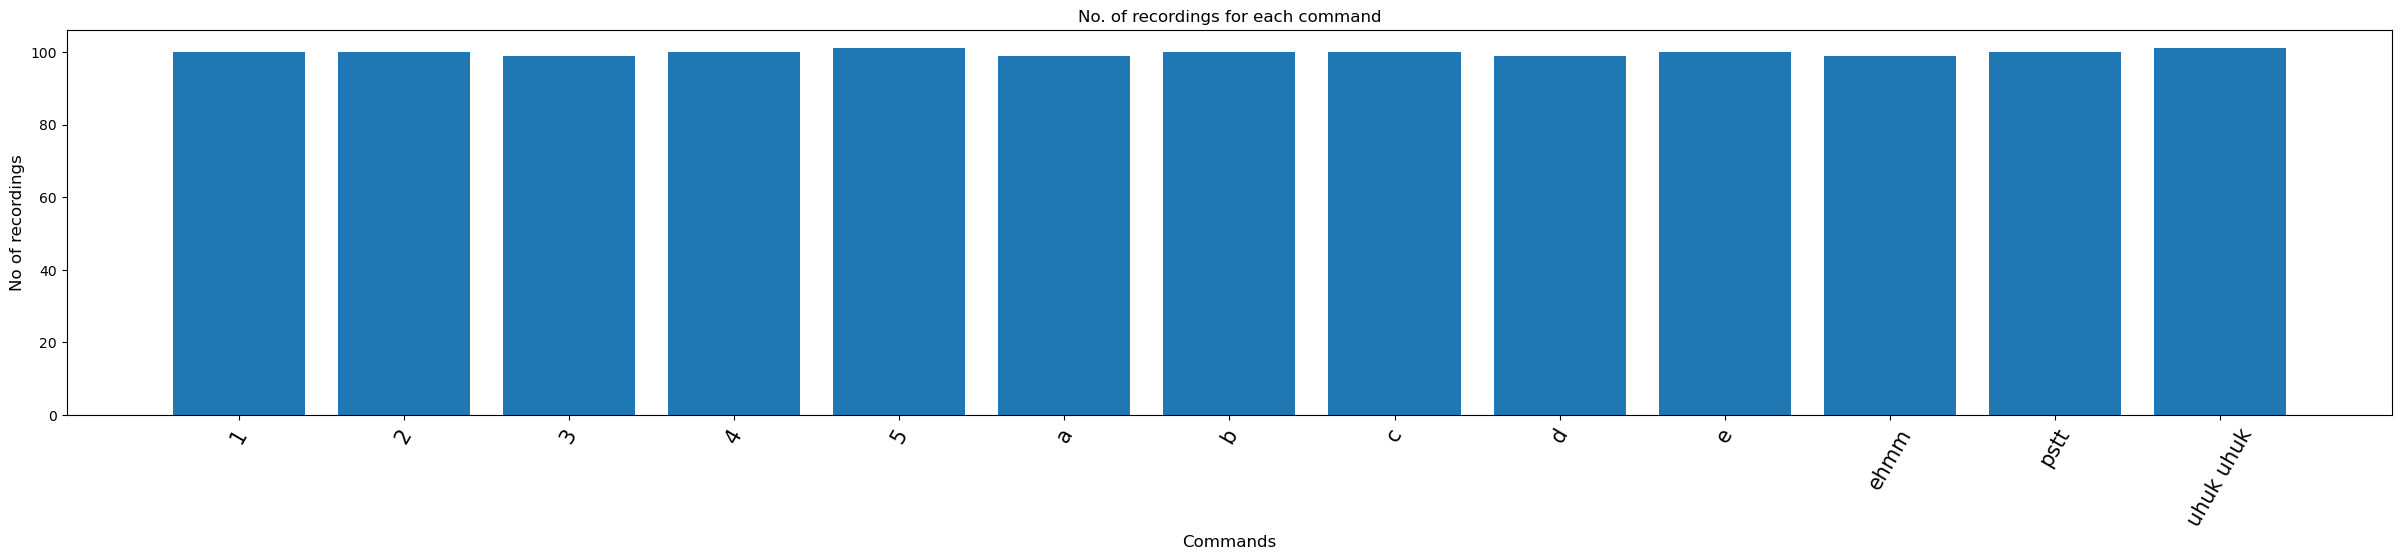

In [24]:
import numpy as np

labels=["1", "2", "3", "4", "5", "a", "b", "c", "d", "e", "ehmm", "pstt", "uhuk uhuk"]

# Find the count of each label and create a bar plot
no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

# Plot the bar chart
plt.figure(figsize=(30, 5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()


(array([ 10.,  13.,  41., 520., 605.,  94.,   6.,   5.,   2.,   2.]),
 array([ 2.35163265,  3.7381542 ,  5.12467574,  6.51119728,  7.89771882,
         9.28424036, 10.6707619 , 12.05728345, 13.44380499, 14.83032653,
        16.21684807]),
 <BarContainer object of 10 artists>)

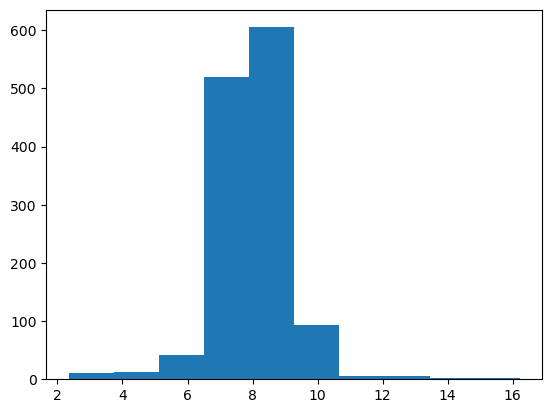

In [27]:
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples) / sample_rate))

plt.hist(np.array(duration_of_recordings))


In [36]:
train_audio_path = 'C:/Users/ASUS/Untitled Folder/Sample-TA/datasets/train/audio'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr=16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) == 8000:
            all_wave.append(samples)
            all_label.append(label)


1


TypeError: resample() takes 1 positional argument but 3 were given

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [33]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [34]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [35]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=42)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [53]:
#Model building
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Defense layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Defense layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

NameError: name 'model' is not defined

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.001)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

NameError: name 'EarlyStopping' is not defined

In [59]:
history = model.fit(
    x_tr, y_tr,
    epochs=100,
    callbacks=[es, mc],
    batch_size=32,
    validation_data=(x_val, y_val)
)

NameError: name 'x_tr' is not defined

In [61]:
#Diagnostic plot
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

In [62]:
#Loading the best model
from keras.models import load_model
model=load_model('best_model.hdf5')

OSError: No file or directory found at best_model.hdf5

In [63]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [66]:
import random 
index = random.randint(0, len(x_val) - 1)
samples = x_val[index].ravel()
print("Audio:", classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

NameError: name 'x_val' is not defined

In [67]:
print("Text:", predict(samples))

ValueError: cannot reshape array of size 132828 into shape (1,8000,1)

In [68]:
!pip install soundfile

In [2]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000
duration = 1 #detik
filename = '1 001.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
               channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [5]:
os.listdir('./datasets/')

NameError: name 'os' is not defined

In [6]:
filepath='./datasets/'

In [1]:
#reading the voice command
samples, sample_rate = librosa.load(filepath + '/' + '0 001.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

NameError: name 'librosa' is not defined

In [2]:
samples.shape

#converting voice commands to text
predict(samples)

NameError: name 'samples' is not defined